## Progressive Pass Clusters

Python implementations of [Finding repeatable progressive pass clusters
and application in international football](https://content.iospress.com/articles/journal-of-sports-analytics/jsa220732) using [Statsbomb Open Data](https://github.com/statsbomb/open-data). The hard part of the work is in the research, so all credit to the team who did it, I'm just implementing it in Python for people who are interested.

If using this, you agree to the terms of Statsbomb Open Data. Views my own as I'm currently employed by Statsbomb, although I don't say anything outlandish.

This notebook uses Polars to handle dataframes, because it's a library I enjoy using. It is easy to convert to pandas dataframes if you so desire.

Instead of looking at international fixtures, I've chosen to use the Premier League in 2015/16. You can change the competition fairly easily, but be a bit mindful that some of the plots might break if the number of teams in the competition changes.

#### General thoughts about the work
- I liked the paper, it was clear and easy enough to follow and implement, and good to see pass clustering used for analysis.
- I don't think it provides much difference to Statsbomb's own [pass clustering](https://statsbomb.com/articles/soccer/statsbomb-release-new-models-expected-pass-xp-and-pass-clustering/), other than only including progressive passes. If I was buying Statsbomb data and had access to their pass clusters, you could get a similar result by manually classifying clusters into progressive/not progressive.
- I don't think there's a big need for modifying the y coordinates. I understand the reasoning, we're interested in forward passes, but if doing team analysis using pass clusters, strength / weakness on one side of the pitch is obscured.
- The SeCo framework seems like a better way of choosing optimal cluster numbers than the elbow method. I'm glad I learned about it. However you do get very different results if you use the k-means++ initialisation for KMeans (and might solve the problem about random initialisation of cluster centroids).

In [1]:
from progressive_pass_clustering.config import OPEN_DATA_PATH
import polars as pl
from statsbombpy import sb
from pathlib import Path
from kloppy import statsbomb
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer.pitch import Pitch

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

#### Dataset

In this, I've elected to stick with Statsbomb dimensions rather than convert to 105x68, as it makes plotting with mplsoccer easier and makes no meaningful difference to the outcome.

In [2]:
competitions = sb.competitions()
competitions[(competitions["season_id"] == 27) & (competitions["competition_id"] == 2)]

competition_id  season_id country_name competition_name  \
62               2         27      England   Premier League   

   competition_gender  competition_youth  competition_international  \
62               male              False                      False   

   season_name               match_updated        match_updated_360  \
62   2015/2016  2023-11-14T11:25:33.476498  2021-06-13T16:17:31.694   

   match_available_360             match_available  
62                None  2023-11-14T11:25:33.476498

In [3]:
matches = sb.matches(2, 27)
match_ids = matches["match_id"].unique().tolist()

In [4]:
match_id_paths = [str(Path(OPEN_DATA_PATH) / "data" / "events"/ f"{match_id}.json") for match_id in match_ids]
lineup_paths = [str(Path(OPEN_DATA_PATH) / "data" / "lineups" / f"{match_id}.json") for match_id in match_ids]

In [5]:
all_passes = []
teams = []
for match_id_path, lineup_path in zip(match_id_paths, lineup_paths):
    data = statsbomb.load(event_data=match_id_path,
                          lineup_data=lineup_path,
                          coordinates="statsbomb",
                          event_types=["pass"])
    all_passes.append(data.to_df(engine="polars"))
    teams.append(data.metadata.teams)

In [6]:
passes = pl.concat(all_passes)

In [7]:
_ = [
    {
        "team_1_id": team[0].team_id,
        "team_1_name": team[0].name,
        "team_2_id": team[1].team_id,
        "team_2_name": team[1].name
    }
    for team in teams]
teams_df = pl.DataFrame(_)
teams_df = teams_df.with_columns(
    pl.col("team_1_id").cast(int),
    pl.col("team_2_id").cast(int)
)
team_mapping = teams_df.group_by("team_1_id").agg(pl.col("team_1_name").first().alias("team_1_name"))
team_mapping_dict = {record["team_1_id"]: record["team_1_name"] for record in team_mapping.to_dicts()}

In [8]:
passes = passes.with_columns(
    pl.col("team_id").cast(int),
    pl.col("player_id").cast(int),
)

passes_filtered = passes.filter(
    pl.col("set_piece_type").is_null(),
    pl.col("body_part_type").is_in(["RIGHT_FOOT", "LEFT_FOOT"]),
    pl.col("pass_type") != "CROSS",
    ~(
        (pl.col("coordinates_x") > 102) &
        (pl.col("coordinates_y") > 18) &
        (pl.col("coordinates_y") < 62)
    )
)

passes_with_modified_y = passes_filtered.with_columns(
    pl.when(
        pl.col("coordinates_y") > 40
    ).then(
        80 - pl.col("coordinates_y"),  
    ).otherwise(
        pl.col("coordinates_y")
    ).alias("modified_y"),
    pl.when(
        pl.col("end_coordinates_y") > 40
    ).then(
        80 - pl.col("end_coordinates_y"),
    ).otherwise(
        pl.col("end_coordinates_y")
    ).alias("modified_end_y"),
)

passes_with_features = passes_with_modified_y.with_columns(
    (
        (pl.col("end_coordinates_x") - pl.col("coordinates_x")) ** 2 +
        (pl.col("end_coordinates_y") - pl.col("coordinates_y")) ** 2
    ).pow(0.5).alias("pass_distance"),
    pl.arctan2(
        pl.col("end_coordinates_y") - pl.col("coordinates_y"),
        pl.col("end_coordinates_x") - pl.col("coordinates_x")
    ).degrees().abs().alias("pass_angle"),
    ((pl.col("end_coordinates_x") - pl.col("coordinates_x")) / (105 - pl.col("coordinates_x"))).alias("vertical_percent_progress"),
    (
        (pl.col("end_coordinates_x") >= 102) &
        (pl.col("end_coordinates_y") >= 18) &
        (pl.col("end_coordinates_y") <= 62)
    ).alias("end_in_box"),
)

I'm unsure of the angle used. In the paper, it says between 105 and -105, but if this was the case and you didn't have the vertical progress constraint, you could have backward passes? I think 75 -> -75 is intended.

In [9]:
progressive_passes = passes_with_features.filter(
    pl.col("vertical_percent_progress") > 0.2,
    pl.col("pass_angle") < 75,
    ~pl.col("end_in_box"),
)
print(progressive_passes.shape)

(35718, 25)


In [10]:
progressive_passes_box = passes_with_features.filter(
    pl.col("vertical_percent_progress") > 0.2,
    pl.col("pass_angle") < 75,
    pl.col("end_in_box"),
)
print(progressive_passes_box.shape)

(7629, 25)


In [11]:
FEATURES = [
    "pass_distance",
    "pass_angle",
    "coordinates_x",
    "end_coordinates_x",
    "modified_y",
    "modified_end_y",
]

BOX_FEATURES = [
    "pass_distance",
    "pass_angle",
    "coordinates_x",
    "modified_y",
]

PLOT_FEATURES = [
    "coordinates_x",
    "end_coordinates_x",
    "coordinates_y",
    "end_coordinates_y",
]

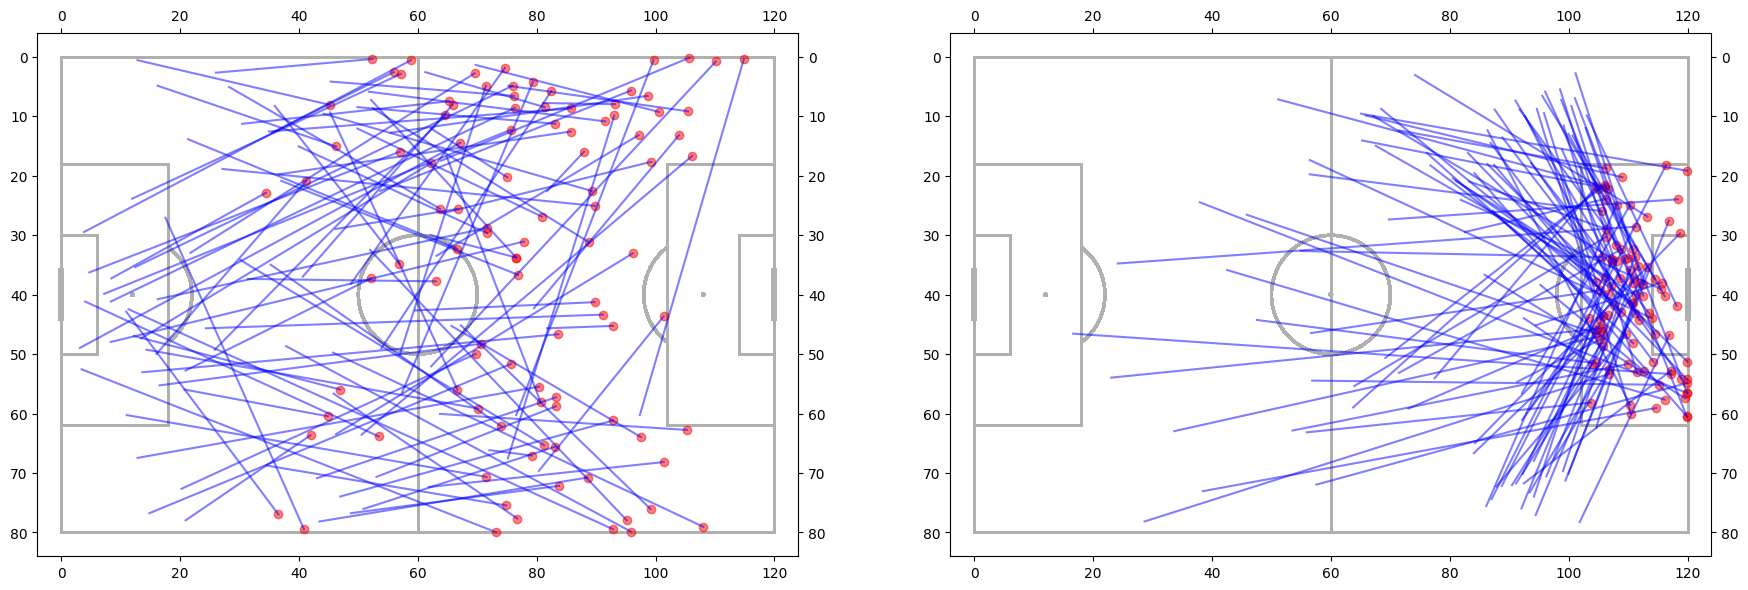

In [12]:
plot_passes = progressive_passes[PLOT_FEATURES].to_numpy()
plot_passes_box = progressive_passes_box[PLOT_FEATURES].to_numpy()

pitch = Pitch(pitch_length=105, pitch_width=68, axis=True, label=True, tick=True)

fig, axs = plt.subplots(1, 2, figsize=(10.8 * 2, 6.8))
for i in range(100):
    pitch.draw(ax=axs[0])
    axs[0].scatter(plot_passes[i, 1], plot_passes[i, 3], c="r", alpha=0.5, label="Pass End")
    axs[0].plot([plot_passes[i, 0], plot_passes[i, 1]], [plot_passes[i, 2], plot_passes[i, 3]], "b", alpha=0.5)
    pitch.draw(ax=axs[1])
    axs[1].scatter(plot_passes_box[i, 1], plot_passes_box[i, 3], c="r", alpha=0.5, label="Pass End")
    axs[1].plot([plot_passes_box[i, 0], plot_passes_box[i, 1]], [plot_passes_box[i, 2], plot_passes_box[i, 3]], "b", alpha=0.5)

### Clustering

#### Elbow plot

In [13]:
inertias = []
inertias_box = []

n_clusters = range(1, 20)

for k in n_clusters:
    pipeline = make_pipeline(MinMaxScaler(), KMeans(n_clusters=k))
    pipeline.fit(progressive_passes[FEATURES].to_numpy())
    inertias.append(pipeline["kmeans"].inertia_)
    pipeline.fit(progressive_passes_box[BOX_FEATURES].to_numpy())
    inertias_box.append(pipeline["kmeans"].inertia_)

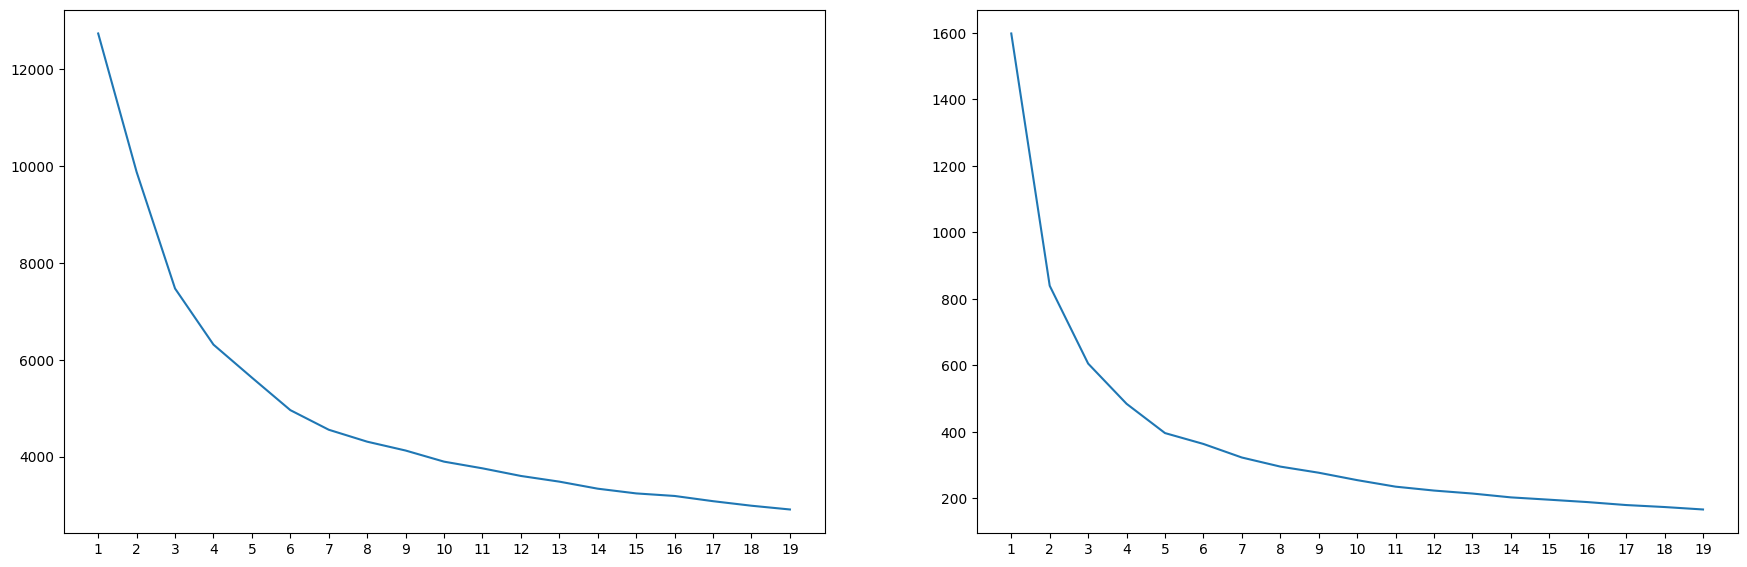

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10.8 * 2, 6.8))
axs[0].plot(n_clusters, inertias)
axs[1].plot(n_clusters, inertias_box)
# Set axis ticks
axs[0].set_xticks(n_clusters)
axs[1].set_xticks(n_clusters)
plt.show()

### SeCo framework

I've only done this for non-box entry passes, as it takes a while to run. Also, as I'm following the paper, I don't need to make the hard decision about choosing the number of clusters.

In [15]:
from sklearn.metrics import confusion_matrix
from scipy.stats.contingency import association
import numpy as np


n_clusters = range(2, 40)
n_bootstrap = 20
records = []

for k in n_clusters:
    for _ in range(n_bootstrap):
        pipeline = make_pipeline(MinMaxScaler(), KMeans(n_clusters=k, init="random"))  # k-means++ is the default
        pipeline.fit(progressive_passes[FEATURES].to_numpy())
        solution = pipeline["kmeans"].labels_
        if _ > 0:
            confusion = confusion_matrix(previous_solution, solution)
            records.append(
                {
                    "k": k,
                    "inertia": pipeline["kmeans"].inertia_,
                    "cramers_v": association(confusion, method='cramer')
                }
            )

        previous_solution = solution


seco_results = pl.DataFrame(records)

In [16]:
seco_top_10 = seco_results.sort("inertia", descending=False).group_by("k").head(int(0.1 * n_bootstrap))

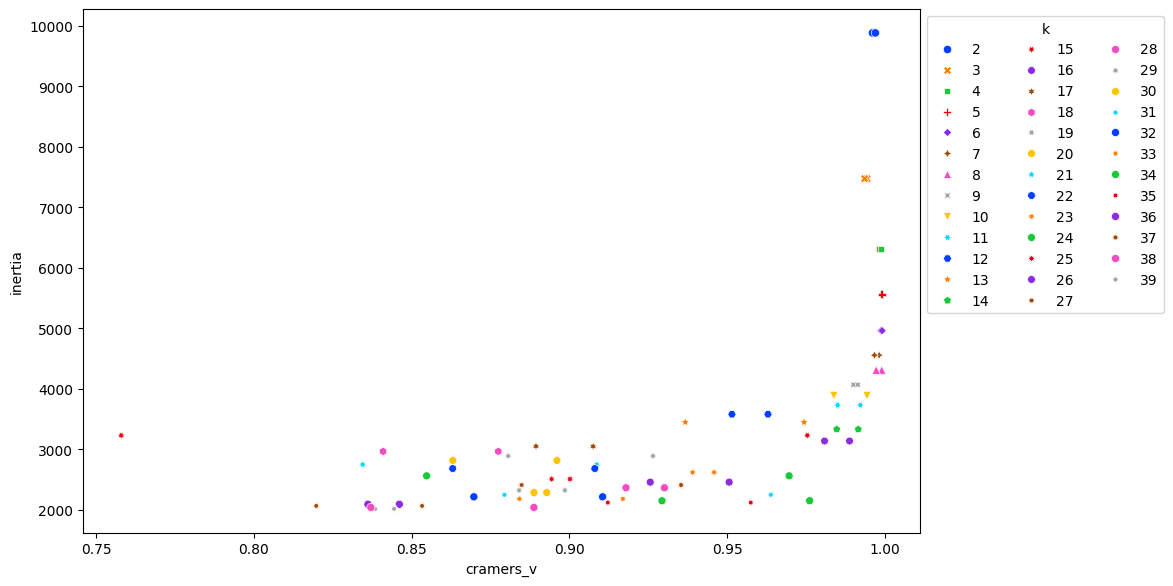

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10.8, 6.8))
sns.scatterplot(x="cramers_v", y="inertia", data=seco_top_10, style=seco_top_10["k"], hue=seco_top_10["k"], ax=axs, palette="bright")
sns.move_legend(axs, "upper left", ncol=3, bbox_to_anchor=(1, 1))

#### Selected models

For inside the penalty box, the paper uses a 10 cluster solution. For outside the penalty box they use 14 clusters. So we'll stick with that for consistency.

In [18]:
model = make_pipeline(MinMaxScaler(), KMeans(n_clusters=14, init="k-means++"))
box_model = make_pipeline(MinMaxScaler(), KMeans(n_clusters=10, init="k-means++"))

model.fit(progressive_passes[FEATURES].to_numpy())
box_model.fit(progressive_passes_box[BOX_FEATURES].to_numpy())

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kmeans', KMeans(n_clusters=10))])

In [19]:
# Save the models
# import joblib
# with open("models/progressive_pass_clustering.pkl", "wb") as f:
#     joblib.dump(model, f)
# with open("models/progressive_pass_clustering_box.pkl", "wb") as f:
#     joblib.dump(box_model, f)

In [20]:
# # Load the models
# with open("models/progressive_pass_clustering.pkl", "rb") as f:
#     model = joblib.load(f)
# with open("models/progressive_pass_clustering_box.pkl", "rb") as f:
#     box_model = joblib.load(f)

In [21]:
progressive_passes = progressive_passes.with_columns(
    pl.Series(model["kmeans"].labels_.tolist()).alias("cluster")
)
progressive_passes_box = progressive_passes_box.with_columns(
    pl.Series(box_model["kmeans"].labels_.tolist()).alias("cluster")
)

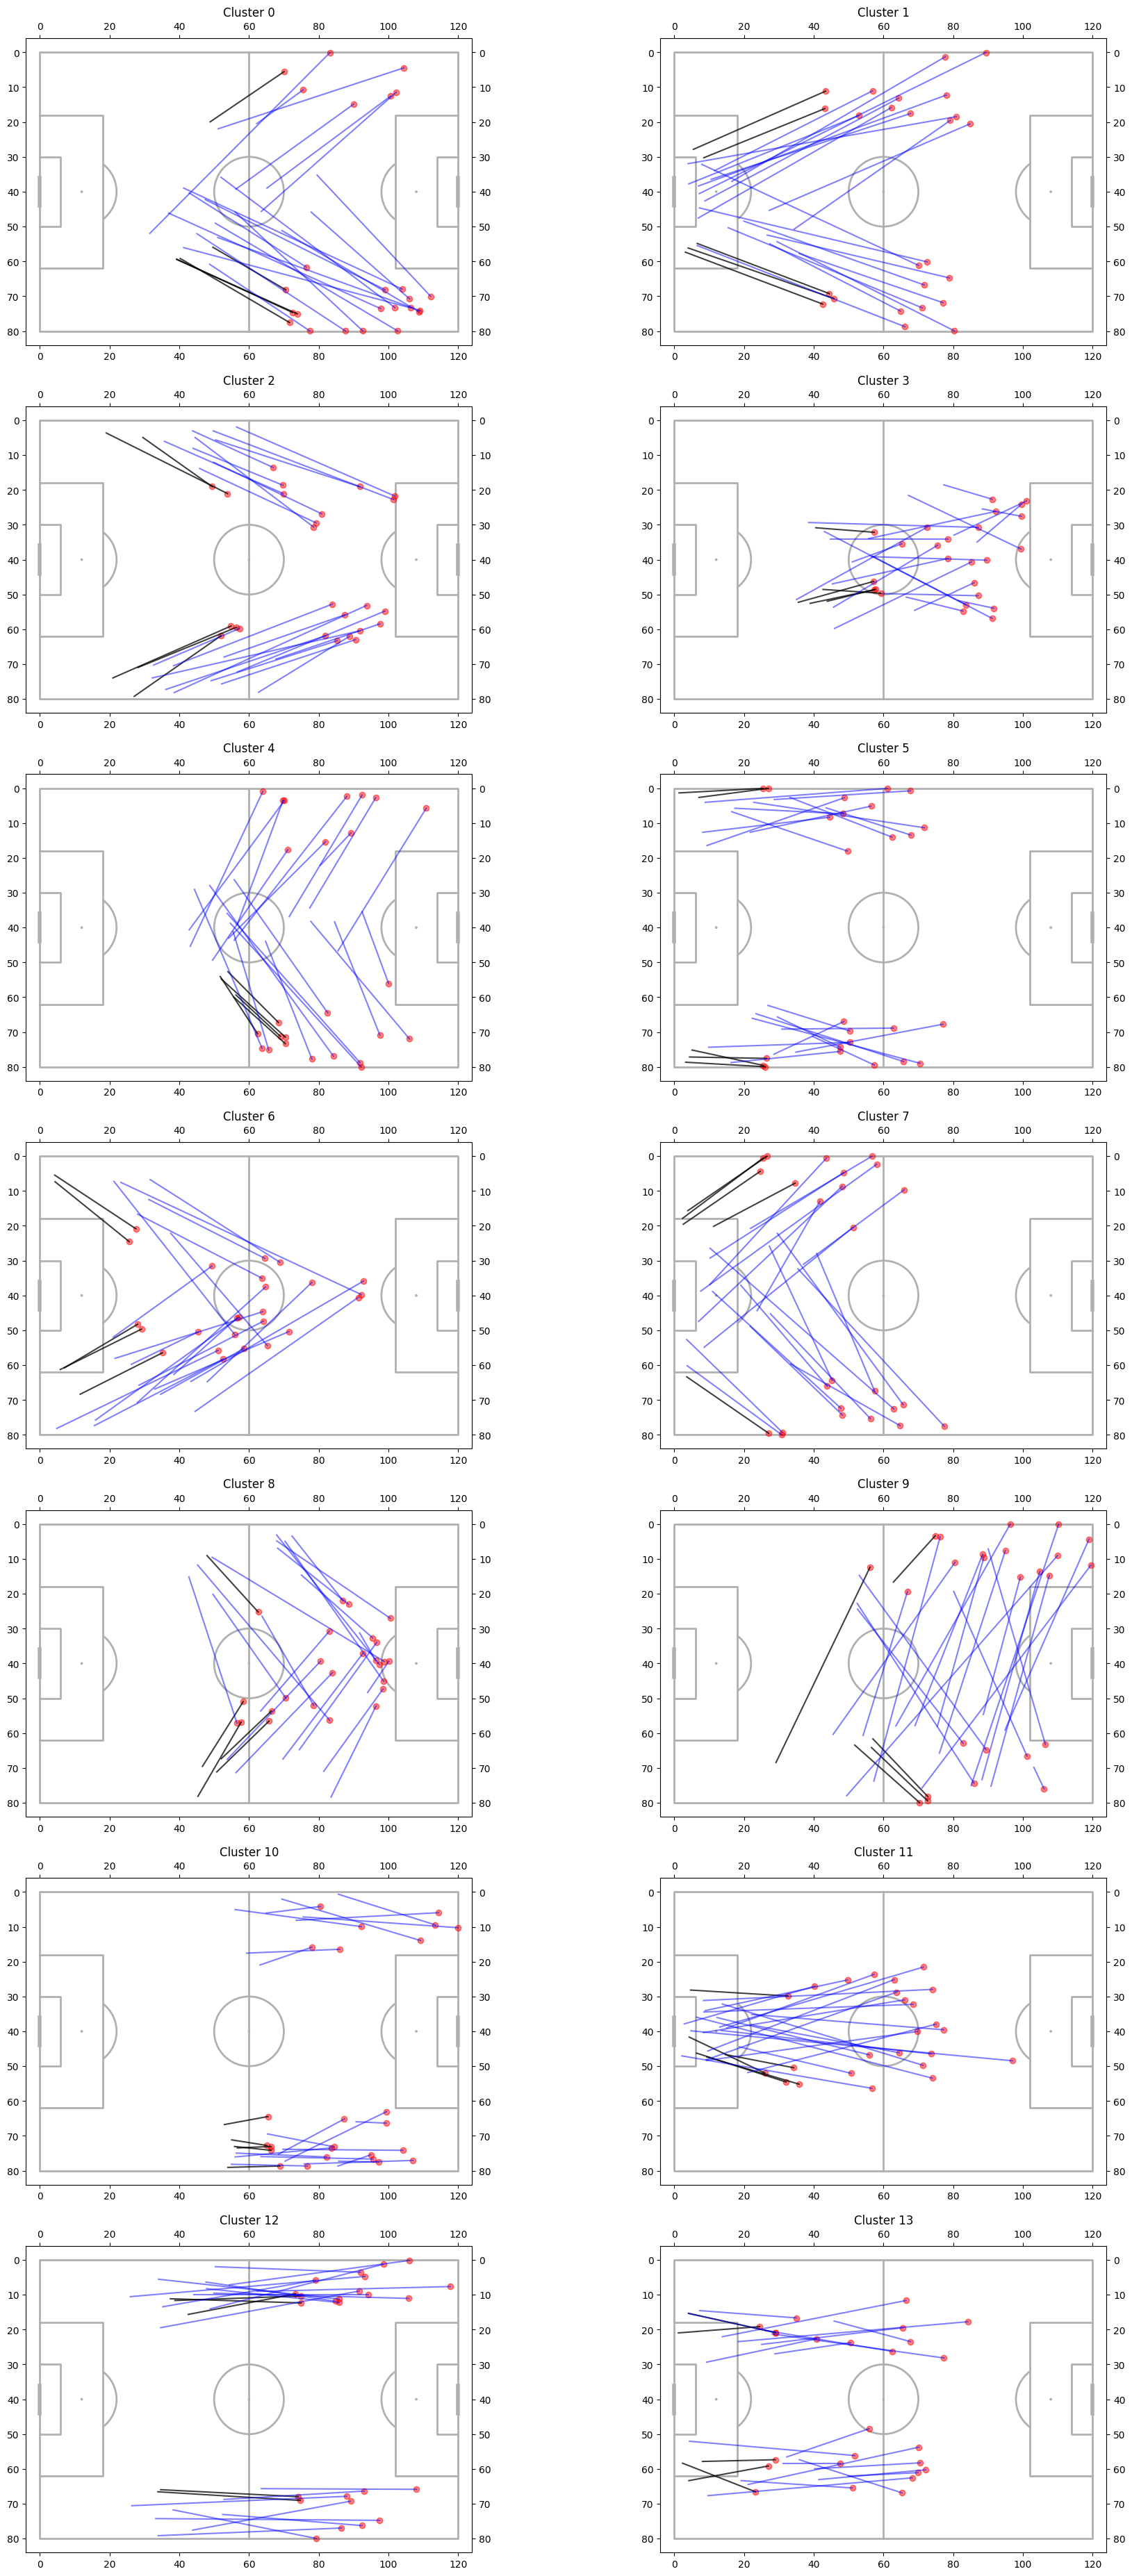

In [22]:
n_clusters = model["kmeans"].n_clusters
centroids = model["kmeans"].cluster_centers_
fig, axs = plt.subplots(n_clusters // 2, 2, figsize=(10.8 * 2, 6.8 * n_clusters // 2))

for i, axs in zip(range(n_clusters), axs.ravel()):
    pitch.draw(ax=axs)
    cluster = progressive_passes.filter(pl.col("cluster") == i)
    centroid = centroids[i]

    dists_to_centroid = cluster.with_columns(
        (
            (pl.col("pass_distance") - centroid[0]) ** 2 +
            (pl.col("pass_angle") - centroid[1]) ** 2 +
            (pl.col("coordinates_x") - centroid[2]) ** 2 +
            (pl.col("end_coordinates_x") - centroid[3]) ** 2 +
            (pl.col("modified_y") - centroid[4]) ** 2 +
            (pl.col("modified_end_y") - centroid[5]) ** 2
        ).pow(0.5).alias("dist_to_centroid")
    )
    most_representative = dists_to_centroid.sort("dist_to_centroid", descending=False).head(5)
    random = cluster.sample(20)

    for record in most_representative.to_dicts():
        axs.scatter(record["end_coordinates_x"],
                    record["end_coordinates_y"], c="r", alpha=0.5, label="Pass End")
        axs.plot([record["coordinates_x"],
                  record["end_coordinates_x"]],
                 [record["coordinates_y"],
                  record["end_coordinates_y"]], "k", alpha=0.75)

    for record in random.to_dicts():
        axs.scatter(record["end_coordinates_x"],
                    record["end_coordinates_y"], c="r", alpha=0.5, label="Pass End")
        axs.plot([record["coordinates_x"],
                  record["end_coordinates_x"]],
                 [record["coordinates_y"],
                  record["end_coordinates_y"]], "b", alpha=0.5)
    axs.set_title(f"Cluster {i}")

10


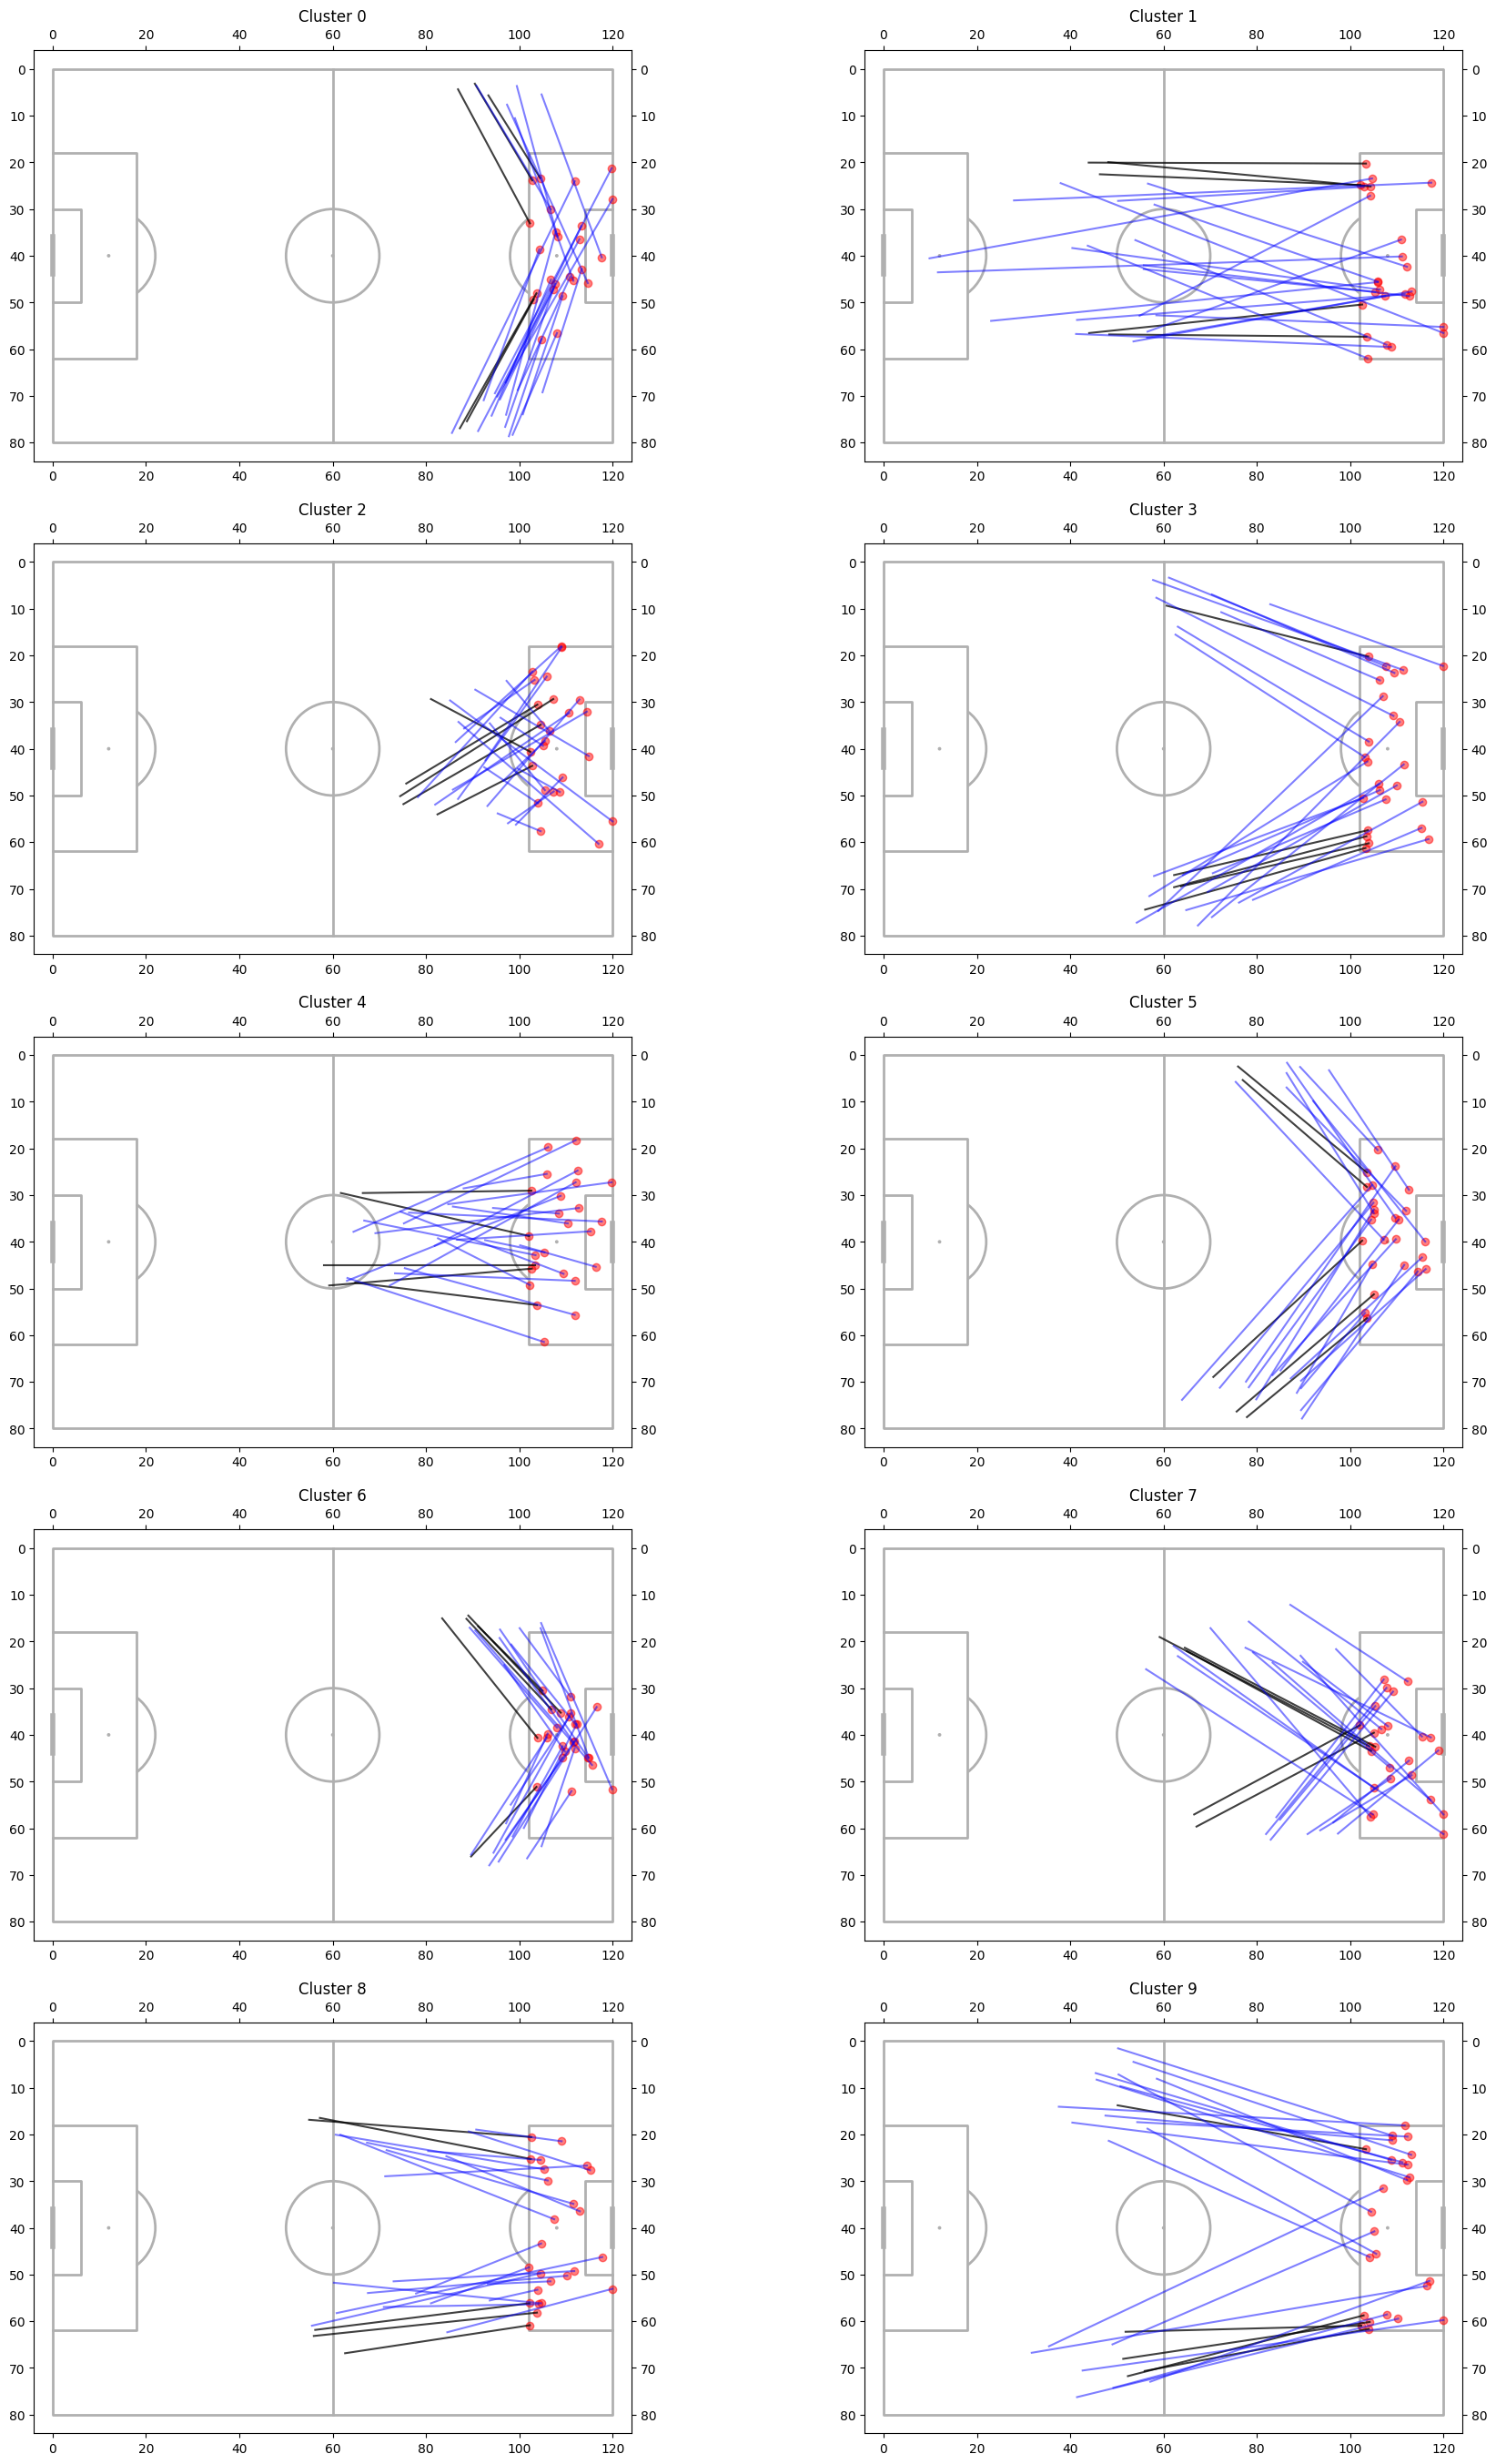

In [23]:
n_clusters = box_model["kmeans"].n_clusters
print(n_clusters)
centroids = box_model["kmeans"].cluster_centers_
fig, axs = plt.subplots(n_clusters // 2, 2, figsize=(10.8 * 2, 6.8 * n_clusters // 2))

for i, axs in zip(range(n_clusters), axs.ravel()):
    pitch.draw(ax=axs)
    cluster = progressive_passes_box.filter(pl.col("cluster") == i)
    centroid = centroids[i]

    dists_to_centroid = cluster.with_columns(
        (
            (pl.col("pass_distance") - centroid[0]) ** 2 +
            (pl.col("pass_angle") - centroid[1]) ** 2 +
            (pl.col("coordinates_x") - centroid[2]) ** 2 +
            (pl.col("modified_y") - centroid[3]) ** 2
        ).pow(0.5).alias("dist_to_centroid")
    )
    most_representative = dists_to_centroid.sort("dist_to_centroid", descending=False).head(5)
    random = cluster.sample(20)

    for record in most_representative.to_dicts():
        axs.scatter(record["end_coordinates_x"],
                    record["end_coordinates_y"], c="r", alpha=0.5, label="Pass End")
        axs.plot([record["coordinates_x"],
                  record["end_coordinates_x"]],
                 [record["coordinates_y"],
                  record["end_coordinates_y"]], "k", alpha=0.75)

    for record in random.to_dicts():
        axs.scatter(record["end_coordinates_x"],
                    record["end_coordinates_y"], c="r", alpha=0.5, label="Pass End")
        axs.plot([record["coordinates_x"],
                  record["end_coordinates_x"]],
                 [record["coordinates_y"],
                  record["end_coordinates_y"]], "b", alpha=0.5)
    axs.set_title(f"Cluster {i}")

#### Team analysis

In [24]:
team_cluster_counts = progressive_passes.group_by(["team_id", "cluster"]).len()
total_cluster_counts = progressive_passes.group_by("cluster").len()
team_cluster_counts = team_cluster_counts.join(total_cluster_counts, on="cluster", how="left")

team_cluster_counts = team_cluster_counts.with_columns(
    (pl.col("len") / pl.col("len_right") * 100).alias("percent_over_baseline")
)

team_most_clusters = team_cluster_counts.sort("percent_over_baseline", descending=True).group_by("team_id").head(3)
team_most_clusters = team_most_clusters.join(team_mapping, left_on="team_id", right_on="team_1_id")

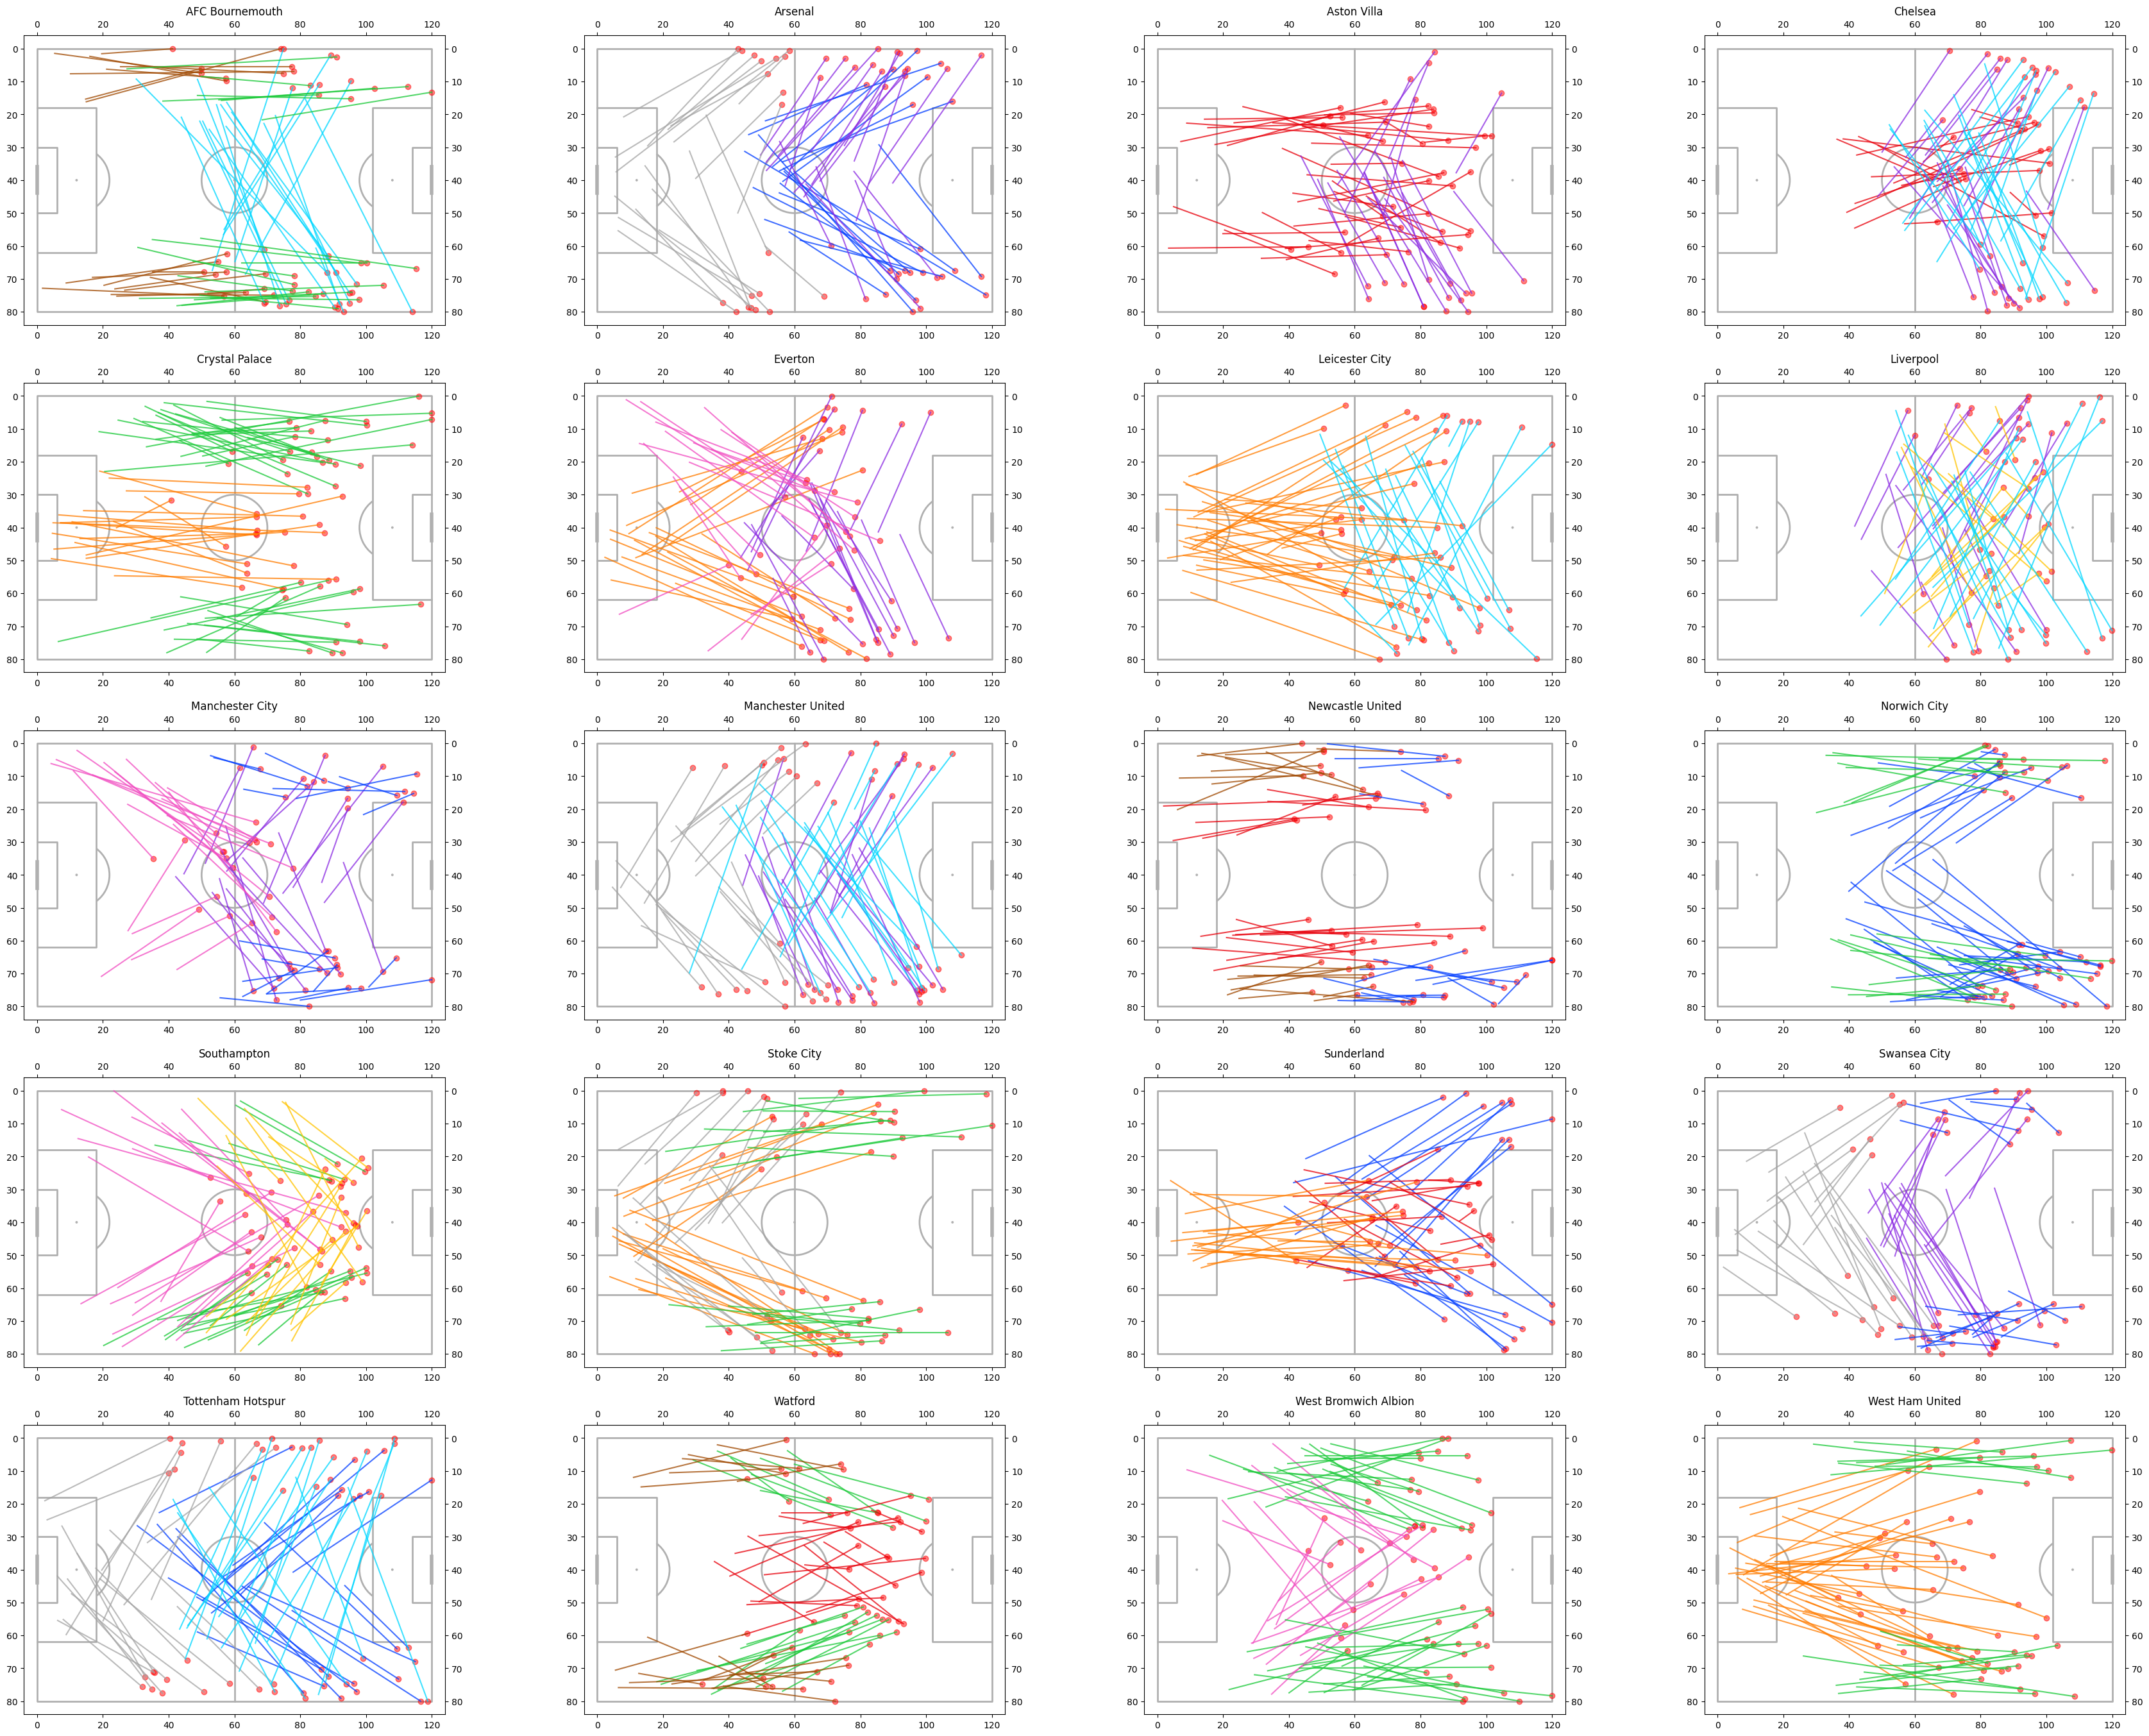

In [28]:
n_teams = team_mapping.shape[0]
n_clusters = model["kmeans"].n_clusters

cluster_color_map = sns.color_palette("bright", n_clusters)

fig, axs = plt.subplots(n_teams // 4, 4, figsize=(10.8 * 4, 6.8 * n_teams // 4))

for team_id, axs in zip(sorted(team_mapping["team_1_id"].to_list(),
                               key=lambda x: team_mapping_dict[x]),
                        axs.ravel()):
    team_name = team_mapping_dict[team_id]
    most_clusters = team_most_clusters.filter(pl.col("team_id") == team_id)
    unique_clusters = most_clusters["cluster"].unique().to_list()
    for cluster in unique_clusters:
        passes = progressive_passes.filter(
            pl.col("team_id") == team_id,
            pl.col("cluster") == cluster).sample(20)
        for record in passes.to_dicts():
            axs.scatter(record["end_coordinates_x"],
                        record["end_coordinates_y"], c="r", alpha=0.5, label="Pass End")
            axs.plot([record["coordinates_x"],
                    record["end_coordinates_x"]],
                    [record["coordinates_y"],
                    record["end_coordinates_y"]], c=cluster_color_map[cluster], alpha=0.75)
    pitch.draw(ax=axs)
    axs.set_title(team_name)
plt.show()

In [26]:
team_cluster_counts_box = progressive_passes_box.group_by(["team_id", "cluster"]).len()
total_cluster_counts_box = progressive_passes_box.group_by("cluster").len()
team_cluster_counts_box = team_cluster_counts_box.join(total_cluster_counts_box, on="cluster", how="left")

team_cluster_counts_box = team_cluster_counts_box.with_columns(
    (pl.col("len") / pl.col("len_right") * 100).alias("percent_over_baseline")
)

team_most_clusters_box = team_cluster_counts_box.sort("percent_over_baseline", descending=True).group_by("team_id").head(3)
team_most_clusters_box = team_most_clusters_box.join(team_mapping, left_on="team_id", right_on="team_1_id")

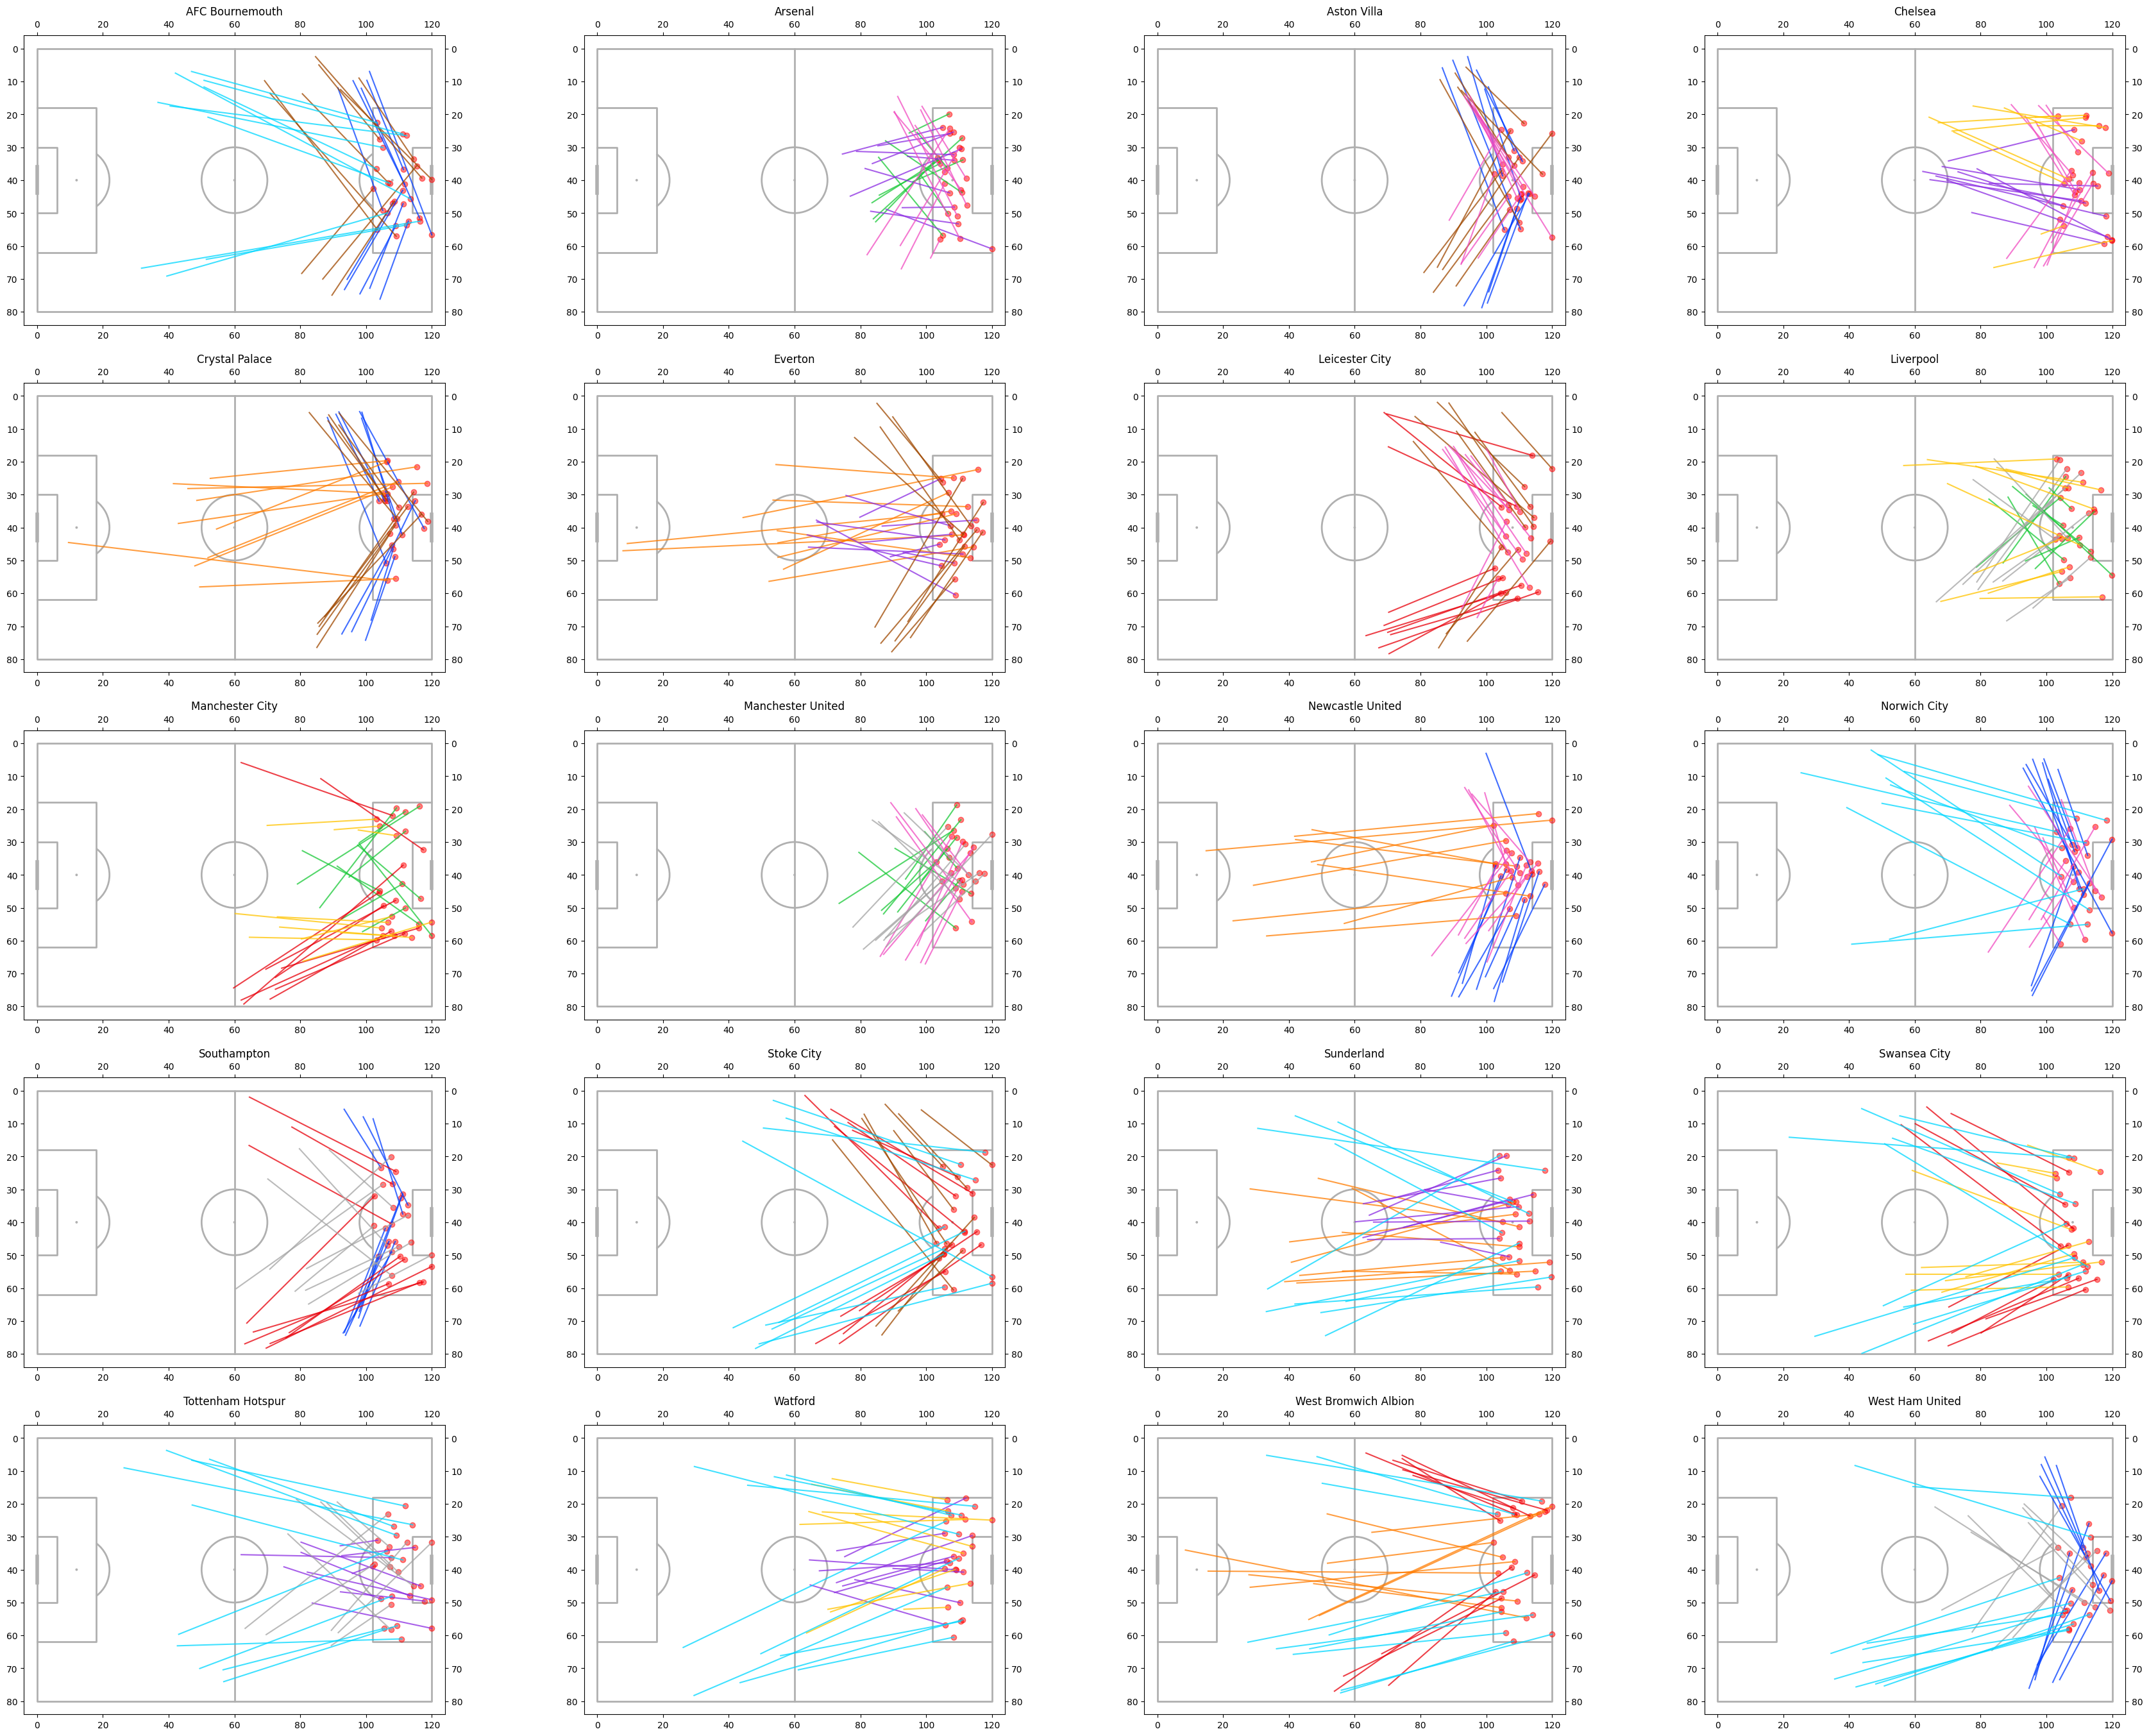

In [27]:
n_teams = team_mapping.shape[0]
n_clusters = box_model["kmeans"].n_clusters

cluster_color_map = sns.color_palette("bright", n_clusters)

fig, axs = plt.subplots(n_teams // 4, 4, figsize=(10.8 * 4, 6.8 * n_teams // 4))

for team_id, axs in zip(sorted(team_mapping["team_1_id"].to_list(),
                               key=lambda x: team_mapping_dict[x]),
                        axs.ravel()):
    team_name = team_mapping_dict[team_id]
    most_clusters = team_most_clusters_box.filter(pl.col("team_id") == team_id)
    unique_clusters = most_clusters["cluster"].unique().to_list()
    for cluster in unique_clusters:
        passes = progressive_passes_box.filter(
            pl.col("team_id") == team_id,
            pl.col("cluster") == cluster).sample(10)
        for record in passes.to_dicts():
            axs.scatter(record["end_coordinates_x"],
                        record["end_coordinates_y"], c="r", alpha=0.5, label="Pass End")
            axs.plot([record["coordinates_x"],
                    record["end_coordinates_x"]],
                    [record["coordinates_y"],
                    record["end_coordinates_y"]], c=cluster_color_map[cluster], alpha=0.75)
    pitch.draw(ax=axs)
    axs.set_title(team_name)